In [1]:
from pathlib import Path

if Path.cwd().stem == "features":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

/Users/visser/drive/PhD/Code/pain-measurement


In [ ]:
import logging
from pathlib import Path

import holoviews as hv
import hvplot.polars
import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
import panel as pn
import plotly.express as px
import polars as pl
import scipy
import scipy.signal as signal

from src.data.config_data import DataConfigBase
from src.data.config_data_raw import RAW_DICT, RAW_LIST, RawConfig
from src.data.config_participant import PARTICIPANT_LIST, ParticipantConfig
from src.data.make_dataset import load_dataset
from src.features.pupillometry import (
    _get_blink_segments,
    add_blink_threshold,
    interpolate_pupillometry,
    remove_periods_around_blinks,
)
from src.features.quality_checks import check_sample_rate
from src.features.transformations import (
    add_timedelta_column,
    interpolate,
    map_participant_datasets,
    map_trials,
    merge_datasets,
    scale_min_max,
    scale_standard,
)
from src.helpers import ensure_list
from src.log_config import configure_logging
from src.visualization.plot_data import (
    plot_data_panel,
    plot_trial_matplotlib,
    plot_trial_plotly,
)

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado", "param"],
)

pl.Config.set_tbl_rows(7)  # don't print too many rows in the book
plt.rcParams["figure.figsize"] = [15, 5]  # default is [6, 4]
hv.extension("plotly");

In [ ]:
participant_number = 0
modality = "pupillometry"
data_config = RAW_DICT[modality]
sampling_rate = data_config.sampling_rate
eye_columns = ["Pupillometry_L", "Pupillometry_R"]

pupillometry_raw = load_dataset(
    PARTICIPANT_LIST[participant_number], RAW_DICT[modality]
).dataset
check_sample_rate(pupillometry_raw)

pupillometry_raw

15:39:51 | DEBUG   | make_dataset | Dataset 'pupillometry' for participant 0 loaded from data/raw/0/0_pupillometry.csv
15:39:51 | DEBUG   | quality_checks | Sample rate per trial: [59.91 59.94 59.93 59.93 59.94 59.93 59.92 59.93 59.93 59.93 59.92 59.93]
15:39:51 | INFO    | quality_checks | The mean sample rate is 59.93.


Timestamp,Pupillometry_L,Pupillometry_R,Pupillometry_L_Distance,Pupillometry_R_Distance,Trial
f64,f64,f64,f64,f64,f64
214220.8889,3.738112,3.884729,611.875427,617.908997,0.0
214240.9759,3.733135,3.88679,611.932007,617.877991,0.0
214257.6095,3.735349,3.880681,612.07782,617.924622,0.0
214274.3519,3.738612,3.882757,611.967957,617.791199,0.0
…,…,…,…,…,…
3.3631e6,2.987041,2.960266,638.944824,640.338257,11.0
3.3631e6,2.981889,2.961481,638.932922,640.33728,11.0
3.3631e6,2.984752,2.963059,638.932922,640.33728,11.0


In [ ]:
def plot(data):
    eye_columns = ["Pupillometry_L", "Pupillometry_R"]
    return data.hvplot(
        x="Timestamp",
        y=eye_columns,
        groupby="Trial",
        kind="line",
        width=800,
        height=400,
    )

### Raw data

In [ ]:
plot(pupillometry_raw)

BokehModel(combine_events=True, render_bundle={'docs_json': {'3c66ce10-1108-40dd-b96f-e9cb455db6a6': {'version…

In [ ]:
EYE_COLUMNS = ["Pupillometry_R", "Pupillometry_L"]

### Standard pipeline
https://github.com/ElioS-S/pupil-size/blob/master/code/Examples/Dataset_1/main_Dataset1.m

1. Filter raw data to only keep 'valid' data without blinks -> filterRawData
2. Interpolate and filte the valid samples -> processValidSamples
3. 

In [ ]:
# Filter raw data
# Reject values < 1.5 and > 9.0 according to Kret et al., 2014
BLINK_THRESHOLD = (1.5, 9.0)


def add_blink_threshold(
    df: pl.DataFrame,
    eye_columns: str | list[str] = EYE_COLUMNS,
    threshold: tuple = BLINK_THRESHOLD,
) -> pl.DataFrame:
    for eye in ensure_list(eye_columns):
        df = df.with_columns(
            pl.when(pl.col(eye) < threshold[0])
            .then(-1)
            .when(pl.col(eye) > threshold[1])
            .then(9.0)
            .otherwise(pl.col(eye))
            .alias(eye)
        )
    return df


pupillometry_thresholded = add_blink_threshold(pupillometry_raw)
plot(pupillometry_thresholded)

BokehModel(combine_events=True, render_bundle={'docs_json': {'f4ef9e95-8e40-4cb8-b9df-4ab2ab527af6': {'version…

In [ ]:
def calculate_d_prime(d, t):
    """
    Vectorized calculation of dilation speed series d'.

    Parameters:
    d (list or array): Data points array.
    t (list or array): Time points array.

    Returns:
    numpy.ndarray: The dilation speed series d'.
    """
    d = np.array(d)
    t = np.array(t)

    # Calculate differences in d and t
    d_diff = np.diff(d)  # d[i+1] - d[i]
    t_diff = np.diff(t)  # t[i+1] - t[i]

    # Avoid division by zero and calculate rates of change
    rates = np.abs(d_diff / t_diff)

    # Calculate max of rates[i-1] and rates[i] for each valid i
    d_prime = np.maximum(rates[:-1], rates[1:])

    return d_prime


def calculate_mad_and_threshold(d_prime, n):
    """
    Calculate the Median Absolute Deviation (MAD) and the threshold for outlier detection.

    Parameters:
    d_prime (numpy.ndarray): The dilation speed series d'.
    n (float): The constant multiplier for MAD.

    Returns:
    tuple: A tuple containing the MAD and the threshold.
    """
    mad = np.median(np.abs(d_prime - np.median(d_prime)))
    threshold = np.median(d_prime) + n * mad

    return mad, threshold


# # Example data
# d = [1, 2, 4, 8, 16]  # Example data points
# t = [1, 2, 3, 4, 5]   # Corresponding time points
d = pupillometry_thresholded["Pupillometry_L"].to_numpy()
t = pupillometry_thresholded["Timestamp"].to_numpy()
n = 16  # as in code dilationSpeedFilter_MadMultiplier


# Calculate d' (dilation speed series)
d_prime = calculate_d_prime(d, t)

# Calculate MAD and threshold
mad, threshold = calculate_mad_and_threshold(d_prime, n)

mad, threshold

(0.0001683019615003914, 0.0030453934903519457)

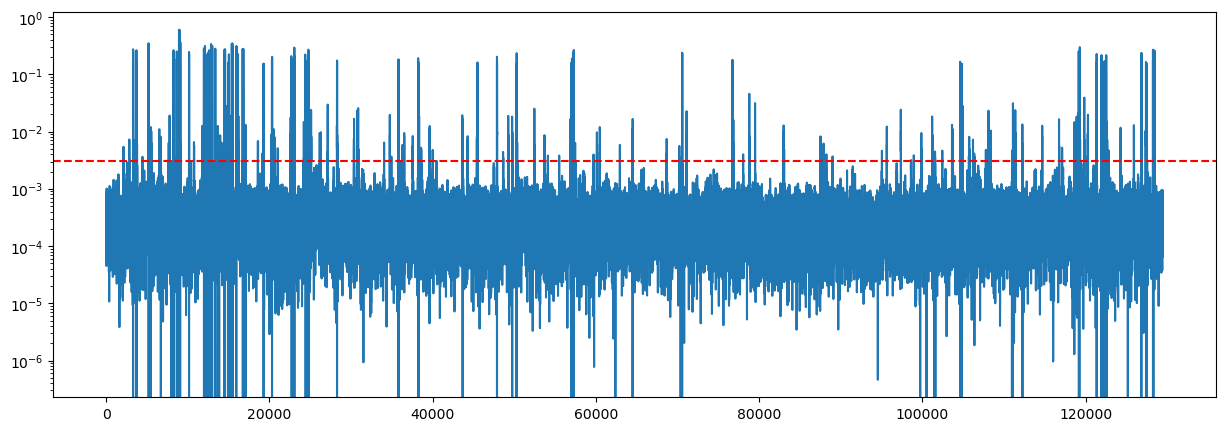

In [ ]:
plt.plot(d_prime)
# x in log
plt.yscale("log")
# add horizontal line for threshold
plt.axhline(threshold, color="red", linestyle="--")

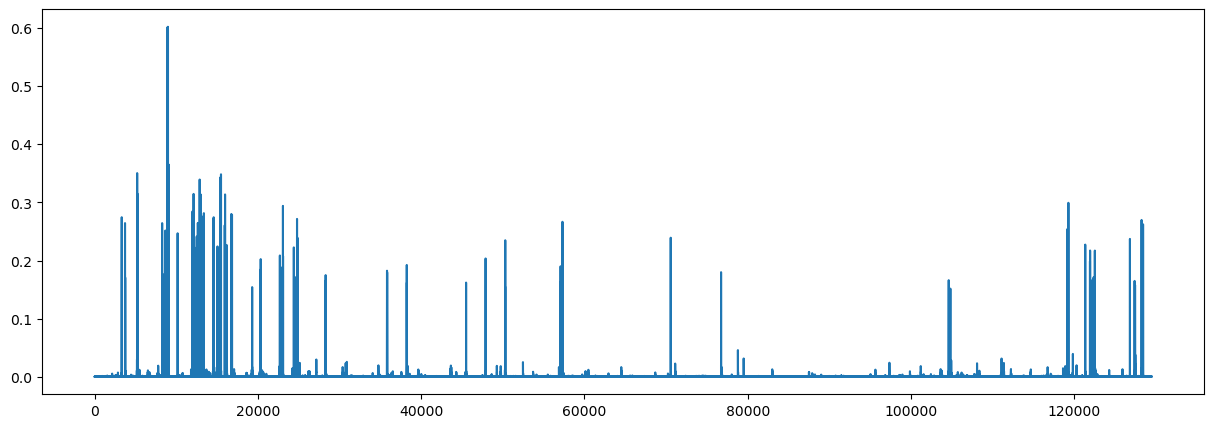

In [ ]:
plt.plot(d_prime)

In [ ]:
d_prime_filtered = np.where(d_prime > threshold, np.nan, d_prime)

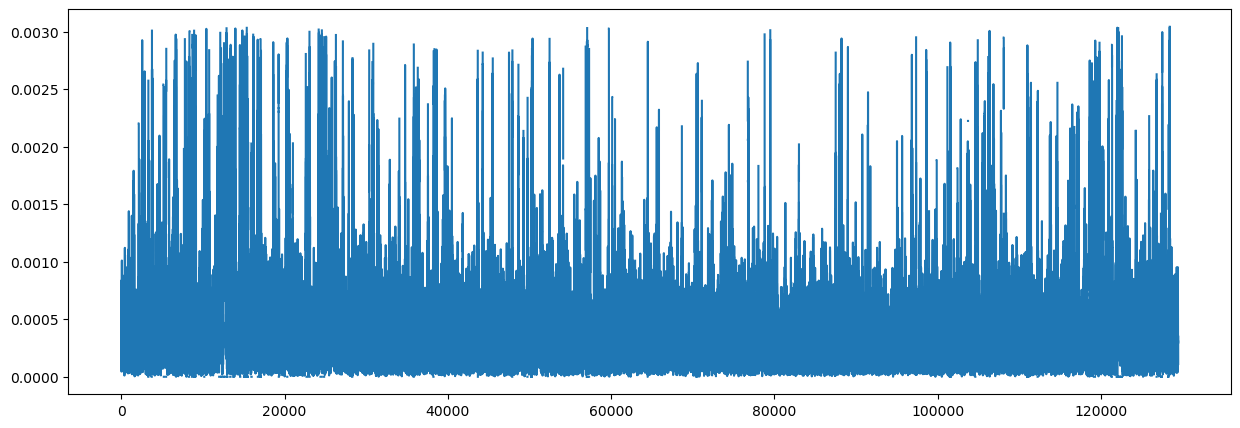

In [ ]:
plt.plot(d_prime_filtered)

In [ ]:
d_prime

array([0.00024778, 0.00019492, 0.00052328, ..., 0.00028954, 0.00030687,
       0.00030687])

In [ ]:
# Blink histogram

results = []
for participant in PARTICIPANT_LIST:
    pupillometry_raw = load_dataset(participant, RAW_DICT[modality]).dataset
    result = pupillometry_raw.group_by("Trial", maintain_order=True).map_groups(
        lambda group: _get_blink_segments(group, eye_columns)
    )
    results.append(result)

pl.concat(results).select("duration").plot.hist(
    bins=1000, title="Blink Duration Distribution"
)

15:39:52 | DEBUG   | make_dataset | Dataset 'pupillometry' for participant 0 loaded from data/raw/0/0_pupillometry.csv
15:39:52 | WARNING | pupillometry | No blinks found in Pupillometry_R for trial 4.
15:39:52 | WARNING | pupillometry | No blinks found in Pupillometry_R for trial 6.
15:39:52 | WARNING | pupillometry | No blinks found in Pupillometry_L for trial 7.
15:39:52 | WARNING | pupillometry | No blinks found in Pupillometry_L for trial 8.
15:39:52 | WARNING | pupillometry | No blinks found in Pupillometry_R for trial 8.
15:39:52 | WARNING | pupillometry | No blinks found in Pupillometry_L for trial 9.
15:39:52 | WARNING | pupillometry | No blinks found in Pupillometry_L for trial 10.
15:39:52 | WARNING | pupillometry | No blinks found in Pupillometry_R for trial 10.
15:39:52 | DEBUG   | make_dataset | Dataset 'pupillometry' for participant 005_leo loaded from data/raw/005_leo/005_leo_pupillometry.csv


:Histogram   [duration]   (duration_count)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def kalman_filter(z, x_est_prev, P_prev, A, H, Q, R):
    """
    Perform a single step of the Kalman filter.

    Parameters:
    z : float or ndarray
        The measurement at the current time step.
    x_est_prev : float or ndarray
        The estimated state at the previous time step.
    P_prev : float or ndarray
        The estimated error covariance at the previous time step.
    A : ndarray
        The state transition model.
    H : ndarray
        The measurement model.
    Q : ndarray
        The process noise covariance.
    R : ndarray
        The measurement noise covariance.

    Returns:
    x_est : ndarray
        Updated state estimate.
    P : ndarray
        Updated estimate covariance.
    """
    # Predict
    x_pred = A @ x_est_prev
    P_pred = A @ P_prev @ A.T + Q

    # Update
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    x_est = x_pred + K @ (z - H @ x_pred)
    P = (np.eye(len(K)) - K @ H) @ P_pred

    return x_est, P


# Example data generation
np.random.seed(0)
n_samples = 100
true_signal = np.linspace(0, 1, n_samples) ** 2
measurements_left_eye = true_signal + 0.05 * np.random.randn(n_samples)
measurements_right_eye = true_signal + 0.05 * np.random.randn(n_samples)

# Measurement matrix (average of both eyes)
measurements = (measurements_left_eye + measurements_right_eye) / 2

# Initializations
x_est_prev = np.array([0])  # initial state estimate
P_prev = np.array([1])  # initial estimate error covariance
A = np.array([1])  # state transition model
H = np.array([1])  # measurement model
Q = np.array([0.001])  # process noise covariance (small)
R = np.array([0.01])  # measurement noise covariance

# Running the Kalman filter
estimates = np.zeros(n_samples)
for i in range(n_samples):
    x_est_prev, P_prev = kalman_filter(measurements[i], x_est_prev, P_prev, A, H, Q, R)
    estimates[i] = x_est_prev

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(true_signal, label="True Signal")
plt.plot(measurements, label="Noisy Measurements", linestyle="dotted")
plt.plot(estimates, label="Kalman Filter Estimates", linestyle="--")
plt.legend()
plt.title("Kalman Filter Smoothing of Pupillometry Data")
plt.xlabel("Time Step")
plt.ylabel("Pupil Size")
plt.show()

ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

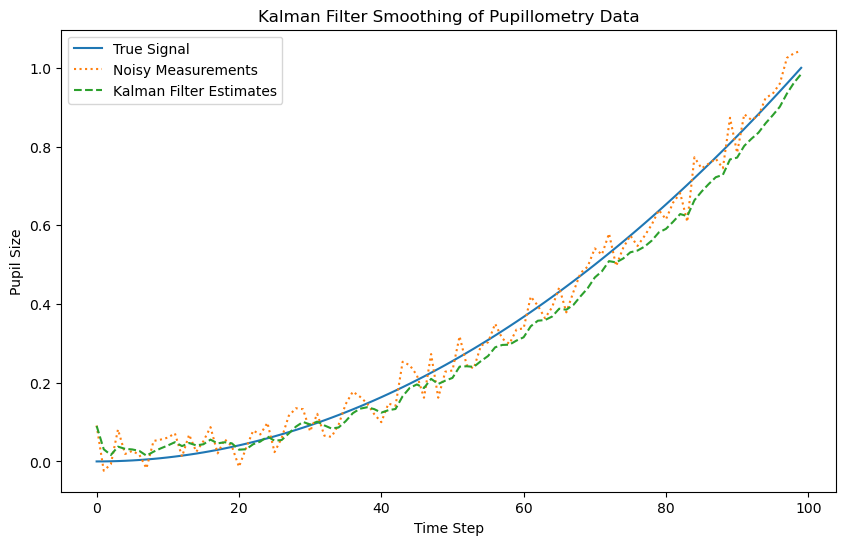

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def kalman_filter(z, x_est_prev, P_prev, A, H, Q, R):
    """
    Perform a single step of the Kalman filter.

    Parameters:
    z : float or ndarray
        The measurement at the current time step.
    x_est_prev : float or ndarray
        The estimated state at the previous time step.
    P_prev : float or ndarray
        The estimated error covariance at the previous time step.
    A : ndarray
        The state transition model.
    H : ndarray
        The measurement model.
    Q : ndarray
        The process noise covariance.
    R : ndarray
        The measurement noise covariance.

    Returns:
    x_est : ndarray
        Updated state estimate.
    P : ndarray
        Updated estimate covariance.
    """
    # Predict
    x_pred = A @ x_est_prev
    P_pred = A @ P_prev @ A.T + Q

    # Update
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    x_est = x_pred + K @ (z - H @ x_pred)
    P = (np.eye(len(K)) - K @ H) @ P_pred

    return x_est, P


# Example data generation
np.random.seed(0)
n_samples = 100
true_signal = np.linspace(0, 1, n_samples) ** 2
measurements_left_eye = true_signal + 0.05 * np.random.randn(n_samples)
measurements_right_eye = true_signal + 0.05 * np.random.randn(n_samples)

# Measurement matrix (average of both eyes)
measurements = (measurements_left_eye + measurements_right_eye) / 2

# Initializations
x_est_prev = np.array([[0]])  # initial state estimate (2D array)
P_prev = np.array([[1]])  # initial estimate error covariance (2D array)
A = np.array([[1]])  # state transition model (2D array)
H = np.array([[1]])  # measurement model (2D array)
Q = np.array([[0.001]])  # process noise covariance (2D array)
R = np.array([[0.01]])  # measurement noise covariance (2D array)

# Running the Kalman filter
estimates = np.zeros(n_samples)
for i in range(n_samples):
    x_est_prev, P_prev = kalman_filter(measurements[i], x_est_prev, P_prev, A, H, Q, R)
    estimates[i] = x_est_prev.item()  # Convert 2D array to scalar for plotting

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(true_signal, label="True Signal")
plt.plot(measurements, label="Noisy Measurements", linestyle="dotted")
plt.plot(estimates, label="Kalman Filter Estimates", linestyle="--")
plt.legend()
plt.title("Kalman Filter Smoothing of Pupillometry Data")
plt.xlabel("Time Step")
plt.ylabel("Pupil Size")
plt.show()

In [ ]:
pupillometry_thresholded["Pupillometry_L"].to_numpy()

In [ ]:
pupil_left = (
    pupillometry_thresholded.filter(pl.col("Trial") == 1)
    .select("Pupillometry_L")
    .to_numpy()
)
pupil_right = (
    pupillometry_thresholded.filter(pl.col("Trial") == 1)
    .select("Pupillometry_R")
    .to_numpy()
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def kalman_filter(z, x_est_prev, P_prev, A, H, Q, R):
    """
    Perform a single step of the Kalman filter.

    Parameters:
    z : float or ndarray
        The measurement at the current time step.
    x_est_prev : float or ndarray
        The estimated state at the previous time step.
    P_prev : float or ndarray
        The estimated error covariance at the previous time step.
    A : ndarray
        The state transition model.
    H : ndarray
        The measurement model.
    Q : ndarray
        The process noise covariance.
    R : ndarray
        The measurement noise covariance.

    Returns:
    x_est : ndarray
        Updated state estimate.
    P : ndarray
        Updated estimate covariance.
    """
    # Predict
    x_pred = A @ x_est_prev
    P_pred = A @ P_prev @ A.T + Q

    # Update
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    x_est = x_pred + K @ (z - H @ x_pred)
    P = (np.eye(len(K)) - K @ H) @ P_pred

    return x_est, P


# Example data generation
np.random.seed(0)
measurements_left_eye = pupil_left
measurements_right_eye = pupil_right
n_samples = len(measurements_left_eye)
# Measurement matrix (average of both eyes)
measurements = (measurements_left_eye + measurements_right_eye) / 2

# Initializations
x_est_prev = np.array([[0]])  # initial state estimate (2D array)
P_prev = np.array([[1]])  # initial estimate error covariance (2D array)
A = np.array([[1]])  # state transition model (2D array)
H = np.array([[1, 1]])  # measurement model (2D array)
Q = np.array([[0.001]])  # process noise covariance (2D array)
R = np.array([[0.01]])  # measurement noise covariance (2D array)

# Running the Kalman filter
estimates = np.zeros(n_samples)
for i in range(n_samples):
    x_est_prev, P_prev = kalman_filter(measurements[i], x_est_prev, P_prev, A, H, Q, R)
    estimates[i] = x_est_prev.item()  # Convert 2D array to scalar for plotting

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(measurements, label="Noisy Measurements", linestyle="dotted")
plt.plot(estimates, label="Kalman Filter Estimates", linestyle="--")
plt.legend()
plt.title("Kalman Filter Smoothing of Pupillometry Data")
plt.xlabel("Time Step")
plt.ylabel("Pupil Size")
plt.show()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 2)

In [ ]:
import numpy as np


def kalman_filter(zs, A, H, Q, R, x0, P0):
    """
    Kalman Filter implementation for smoothing and combining data.

    Parameters:
    - zs : array-like, shape (n_samples, 2)
        Measurements for both eyes at each time step.
    - A : ndarray, shape (1, 1)
        State transition matrix.
    - H : ndarray, shape (1, 2)
        Measurement model.
    - Q : ndarray, shape (1, 1)
        Process noise covariance.
    - R : ndarray, shape (1, 1)
        Measurement noise covariance.
    - x0 : ndarray, shape (1,)
        Initial state estimate.
    - P0 : ndarray, shape (1, 1)
        Initial estimate error covariance matrix.

    Returns:
    - xs : ndarray, shape (n_samples,)
        Filtered state estimates.
    """
    # Number of measurements
    n_samples = len(zs)
    xs = np.zeros(n_samples)
    x = x0
    P = P0

    for i in range(n_samples):
        # Prediction
        x_pred = A @ x
        P_pred = A @ P @ A.T + Q

        # Measurement update
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T @ np.linalg.inv(S)
        x = x_pred + K @ (zs[i] - H @ x_pred)
        P = P_pred - K @ H @ P_pred

        # Store the state
        xs[i] = x

    return xs


# Parameters
A = np.array([[1]])  # State transition matrix
H = np.array([[1, 1]])  # Measurement model to combine both eyes
Q = np.array([[1e-5]])  # Process noise covariance
R = np.array([[1e-2]])  # Measurement noise covariance
x0 = np.array([0])  # Initial state
P0 = np.array([[1]])  # Initial covariance

# Example data (replace this with your actual data)
# Each element in the list is a tuple (measurement_left_eye, measurement_right_eye)
data = [(3.0, 3.1), (2.9, 3.0), (3.2, 3.2), (3.1, 3.1)]

# Applying the Kalman filter
filtered_data = kalman_filter(np.array(data), A, H, Q, R, x0, P0)

print("Filtered Data:", filtered_data)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 2)

In [ ]:
import numpy as np


def kalman_filter(zs, A, H, Q, R, x0, P0):
    """
    Kalman Filter implementation for smoothing and combining data.

    Parameters:
    - zs : array-like, shape (n_samples, 2)
        Measurements for both eyes at each time step.
    - A : ndarray, shape (1, 1)
        State transition matrix.
    - H : ndarray, shape (1, 2)
        Measurement model.
    - Q : ndarray, shape (1, 1)
        Process noise covariance.
    - R : ndarray, shape (2, 2)
        Measurement noise covariance.
    - x0 : ndarray, shape (1,)
        Initial state estimate.
    - P0 : ndarray, shape (1, 1)
        Initial estimate error covariance matrix.
    """
    n_samples = len(zs)
    xs = np.zeros(n_samples)
    x = x0
    P = P0

    for i in range(n_samples):
        # Prediction
        x_pred = A @ x
        P_pred = A @ P @ A.T + Q

        # Measurement update
        y = zs[i] - H @ x_pred
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T @ np.linalg.inv(S)
        x = x_pred + K @ y
        P = P_pred - K @ H @ P_pred

        # Store the state
        xs[i] = x

    return xs


# Parameters
A = np.array([[1]])  # State transition matrix
H = np.array([[1, 1]])  # Measurement model
Q = np.array([[1e-5]])  # Process noise covariance
R = np.array(
    [[1e-2, 0], [0, 1e-2]]
)  # Measurement noise covariance, assuming independence
x0 = np.array([0])  # Initial state
P0 = np.array([[1]])  # Initial covariance

# Example data
data = [(3.0, 3.1), (2.9, 3.0), (3.2, 3.2), (3.1, 3.1)]
filtered_data = kalman_filter(np.array(data), A, H, Q, R, x0, P0)

print("Filtered Data:", filtered_data)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 2)

In [ ]:
import numpy as np


def kalman_filter(
    z,
    x_esti=None,
    P_esti=None,
    A=np.array([[1]]),
    H=np.array([[1, 1]]),
    Q=0.01,
    R=np.array([[0.1, 0], [0, 0.1]]),
):
    """
    Kalman filter algorithm for one step with multi-dimensional measurement.

    :param z: Measurement at current time step (2x1 matrix for two eyes)
    :param x_esti: Last estimation (scalar for unified pupil size estimate)
    :param P_esti: Last estimated error covariance (scalar if state is scalar)
    :param A: State transition model (1x1 matrix for scalar state)
    :param H: Measurement model (1x2 matrix for mapping two measurements to one state)
    :param Q: Process noise covariance (scalar if state is scalar)
    :param R: Measurement noise covariance (2x2 matrix for measurements from two eyes)
    :return: Updated state estimate and error covariance
    """
    if x_esti is None:
        x_esti = np.array([[0]])  # Initial state estimate
    if P_esti is None:
        P_esti = np.array([[1]])  # Initial error covariance

    # Time Update (Prediction)
    x_pred = A @ x_esti
    P_pred = A @ P_esti @ A.T + Q

    # Measurement Update (Correction)
    K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)
    x_esti = x_pred + K @ (z - H @ x_pred)
    P_esti = (np.eye(len(K)) - K @ H) @ P_pred

    return x_esti, P_esti


# Data simulation and filter application would follow similarly, adapting to vector measurements.
# Example data: random measurements of pupil sizes from both eyes
np.random.seed(0)
data_left_eye = np.random.normal(loc=30, scale=5, size=50)
data_right_eye = np.random.normal(loc=30, scale=5, size=50)
combined_measurements = np.vstack((data_left_eye, data_right_eye)).T  # shape (n, 2)

# Kalman Filter initialization
x_esti, P_esti = None, None

# Applying the Kalman Filter on the measurements
smoothed_data = []
for measurement in combined_measurements:
    z = measurement.reshape(-1, 1)  # measurement model
    x_esti, P_esti = kalman_filter(z, x_esti, P_esti)
    smoothed_data.append(x_esti.flatten())

smoothed_data = np.array(smoothed_data)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 1)

In [ ]:
import numpy as np
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import KalmanFilter

my_filter = KalmanFilter(dim_x=2, dim_z=1)

NOTE: maybe add length condition to separate blinks from head turn + larger gaps fot the latter?